In [126]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [127]:
#4.a - Pre-processing - Creating a noisy image
def video_to_frames(vid_path: str, start_second, end_second):
    """
    Load a video and return its frames from the wanted time range.
    :param vid_path: video file path.
    :param start_second: time of first frame to be taken from the
    video in seconds.
    :param end_second: time of last frame to be taken from the
    video in seconds.
    :return:
    frame_set: a 4D uint8 np array of size [num_of_frames x H x W x C]
    containing the wanted video frames.
    """

    #calculate desired frames 
    cap = cv2.VideoCapture(vid_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    start_fr = start_second*fps
    end_fr = end_second*fps
    num_of_frames = 1 + (end_fr-start_fr) 

    #get the desired frames
    frames = []
    i = 0
    curr_fr = 0

    while ( i<num_of_frames):
        valid, img = cap.read() # read one frame from the 'capture' object; img is (H, W, C)
        curr_fr += 1
        if (curr_fr >= start_fr): #if started to get inside the desired section, save frame
            frames.append(img)
            i += 1
    frame_set = np.array(frames) # convert to np array,dimensions (T*fps, H, W, C)
    
    cap.release()

    return frame_set

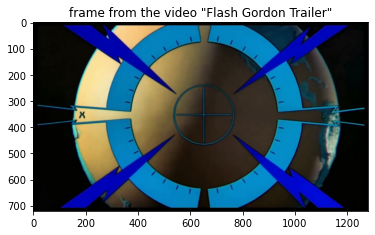

In [128]:
#Display a frame from the time section 00:20 as a color image
frame = video_to_frames("../given_data/Flash Gordon Trailer.mp4", 20, 21)[0]
plt.title('frame from the video "Flash Gordon Trailer"')
plt.imshow(frame)
plt.show()


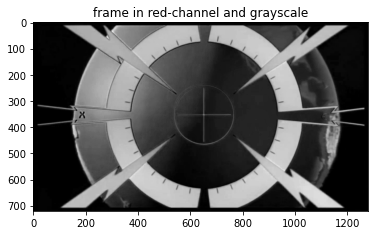

In [129]:

# Select the red channel of the image
frame_red_channel = frame[:,:,2]
plt.title('frame in red-channel and grayscale')
plt.imshow(frame_red_channel, cmap='gray')
plt.show() 


In [130]:
image_height, image_width = frame_red_channel.shape
new_height = int(image_height * 0.5)
new_width = int(image_width * 0.5)
smaller_frame = cv2.resize(frame_red_channel, (new_width, new_height))

In [131]:
def poisson_noisy_image(X, a):
    """
    Creates a Poisson noisy image.
    :param X: The Original image. np array of size [H x W] and of type uint8.
    :param a: number of photons scalar factor
    :return:
    Y: The noisy image. np array of size [H x W] and of type uint8.
    """
    # Convert the image to float and multiply by the number of photons scalar factor
    X_float = X.astype(float) * a

    # Create a Poisson-distributed random noise image
    possion_noise = np.random.poisson(X_float)
    Y = possion_noise.astype(float)
    Y /= a

    # Clip the image to the range [0, 255] to ensure it is still a valid image
    Y = np.clip(Y, 0, 255).astype(np.uint8)

    return Y


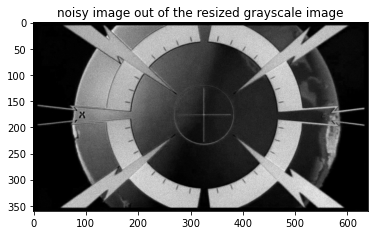

In [132]:
noisy_image = poisson_noisy_image(smaller_frame, 3)
plt.title("noisy image out of the resized grayscale image")
plt.imshow(noisy_image, cmap='gray')
plt.show()

In [133]:
### 4.b - Denoise by L2 ###


def denoise_by_l2(Y, X, num_iter, lambda_reg):
    """
    L2 image denoising.
    :param Y: The noisy image. np array of size [H x W]
    :param X: The Original image. np array of size [H x W]
    :param num_iter: the number of iterations for the algorithm perform
    :param lambda_reg: the regularization parameter
    :return:
         Xout: The restored image. np array of size [H x W]
         Err1: The error between Xk at every iteration and Y.
             np array of size [num_iter]
         Err2: The error between Xk at every iteration and X.
             np array of size [num_iter]
     """
     # ====== YOUR CODE: ======
    
    # Initialize variables
    Yc = Y.flatten('F')
    Xc = Yc
    Xc_original = X.flatten('F')
    kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])  # Laplacian kernel
    
    Err1 = np.zeros(num_iter)  
    Err2 = np.zeros(num_iter)
    
    for i in range(num_iter):
        
        DX = cv2.filter2D(np.reshape(Xc, X.shape, order='F'), -1, kernel, borderType=cv2.BORDER_CONSTANT)
        LDDX = lambda_reg * cv2.filter2D(DX, -1, kernel, borderType=cv2.BORDER_CONSTANT)
        LDDXc = LDDX.flatten('F')
        Gc = Xc + LDDXc - Yc
        
        DG = cv2.filter2D(np.reshape(Gc, Y.shape, order='F'), -1, kernel, borderType=cv2.BORDER_CONSTANT)
        LDDG = lambda_reg * cv2.filter2D(DG, -1, kernel, borderType=cv2.BORDER_CONSTANT)
        LDDGc = LDDG.flatten('F') 
        
        u_nom = np.matmul(np.transpose(Gc), Gc)
        u_den = u_nom + np.matmul(np.transpose(Gc), LDDGc)        
        u_k = (u_nom / u_den)
        
        #calculate errors
        Xc = Xc - u_k*Gc
        DXc = DX.flatten('F') 
        Err1[i] = np.matmul(np.transpose(Xc - Yc), (Xc - Yc)) + lambda_reg*np.matmul(np.transpose(DXc), DXc)
        Err2[i] = np.matmul(np.transpose(Xc - Xc_original), (Xc - Xc_original))
        

        Xout = np.reshape(Xc, X.shape, order='F')
        
    # ========================

    return Xout, Err1, Err2

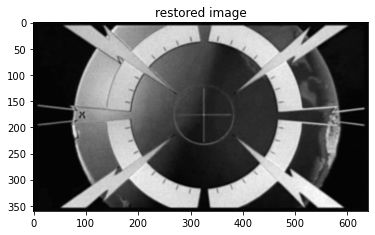

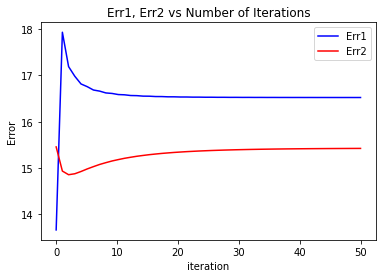

In [134]:
denoised_img, Err1, Err2 = denoise_by_l2(noisy_image, smaller_frame, 50, 0.5)

plt.title("restored image")
plt.imshow(denoised_img, cmap='gray')
plt.show()


plt.title("Err1, Err2 vs Number of Iterations")
plt.xlabel("iteration")
plt.ylabel("Error")
plt.plot(np.linspace(0, 50, 50), np.log(Err1), "-b", label="Err1")
plt.plot(np.linspace(0, 50, 50), np.log(Err2), "-r", label="Err2")
plt.legend(loc="upper right")
plt.show()



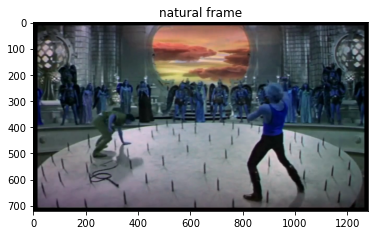

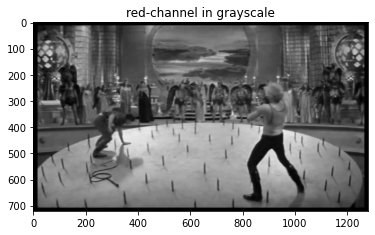

In [135]:
# 4.c - From synthetic to natural

frame = video_to_frames("../given_data/Flash Gordon Trailer.mp4", 38, 38)[0]
plt.title('natural frame')
plt.imshow(frame)
plt.show()

frame_red_channel = frame[:,:,2]
plt.title('red-channel in grayscale')
plt.imshow(frame_red_channel, cmap='gray')
plt.show() 

image_height, image_width = frame_red_channel.shape
new_height = int(image_height * 0.5)
new_width = int(image_width * 0.5)
smaller_frame = cv2.resize(frame_red_channel, (new_width, new_height))

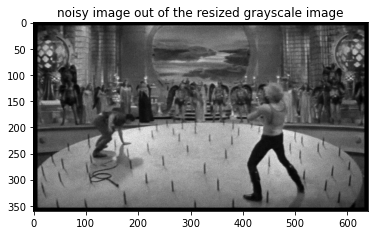

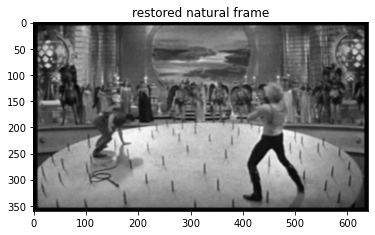

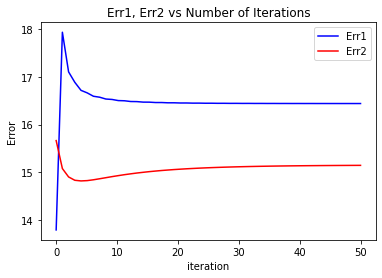

In [136]:
noisy_image = poisson_noisy_image(smaller_frame, 3)
plt.title("noisy image out of the resized grayscale image")
plt.imshow(noisy_image, cmap='gray')
plt.show()

natural_denoised_img, Err1, Err2 = denoise_by_l2(noisy_image, smaller_frame, 50, 0.5)

plt.title("restored natural frame")
plt.imshow(natural_denoised_img, cmap='gray')
plt.show()

plt.title("Err1, Err2 vs Number of Iterations")
plt.xlabel("iteration")
plt.ylabel("Error")
plt.plot(np.linspace(0, 50, 50), np.log(Err1), "-b", label="Err1")
plt.plot(np.linspace(0, 50, 50), np.log(Err2), "-r", label="Err2")
plt.legend(loc="upper right")
plt.show()

